# **DNSC6314 Assignments: Capital Bikeshare**

## - In these assignments, you will follow the steps of the BA workflow.
## - The first assignment focuses on data preparation and training simple models.
## - Continue with the same .ipynb file, the subsequent assignments will delve into more advanced modeling and evaluating model performance.

## <font color="red">Note: acknowledge and cite GenAI if used.</font>


## Capital Bikeshare Data
https://ride.capitalbikeshare.com/system-data

We deal with data from two months: 2024/03 and 2024/10.

### Read data from drive or local

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
# Read csv files

df_Feb = pd.read_csv('/content/drive/My Drive/GW_Class/DNSC6314/Assignments/Data/202402-capitalbikeshare-tripdata.csv')
df_Mar = pd.read_csv('/content/drive/My Drive/GW_Class/DNSC6314/Assignments/Data/202403-capitalbikeshare-tripdata.csv')
df_Apr = pd.read_csv('/content/drive/My Drive/GW_Class/DNSC6314/Assignments/Data/202404-capitalbikeshare-tripdata.csv')

# concat data
df=pd.concat([df_Feb, df_Mar,df_Apr])

In [ ]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,started_at_date,ended_at_date
0,24DBACC298E33BF6,electric_bike,2024-02-01 21:18:50,2024-02-01 21:27:36,Eckington Pl & Q St NE,31505.0,5th & K St NW,31600.0,38.910893,-77.005023,38.90304,-77.019027,member,2024-02-01,2024-02-01
1,FE1067800A18BC56,electric_bike,2024-02-06 17:15:33,2024-02-06 17:30:33,4th & C St SW,31243.0,NaN,NaN,38.886443,-77.017388,38.91000,-76.980000,member,2024-02-06,2024-02-06
2,AD1962B215B5879D,electric_bike,2024-02-26 13:19:42,2024-02-26 13:30:44,North Capitol St & F St NW,31624.0,NaN,NaN,38.896907,-77.009684,38.90000,-77.010000,member,2024-02-26,2024-02-26
3,3F8352E6D9EC4F85,electric_bike,2024-02-02 11:01:22,2024-02-02 11:05:14,1st & K St NE,31662.0,NaN,NaN,38.902394,-77.005614,38.90000,-77.010000,member,2024-02-02,2024-02-02
4,D656DA87FA915F14,electric_bike,2024-02-25 08:28:18,2024-02-25 08:48:44,Virginia Ave & 25th St NW,31297.0,NaN,NaN,38.898456,-77.053075,38.91000,-77.060000,member,2024-02-25,2024-02-25


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1245899 entries, 0 to 490264
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             1245899 non-null  object 
 1   rideable_type       1245899 non-null  object 
 2   started_at          1245899 non-null  object 
 3   ended_at            1245899 non-null  object 
 4   start_station_name  1061748 non-null  object 
 5   start_station_id    1061748 non-null  float64
 6   end_station_name    1052421 non-null  object 
 7   end_station_id      1052253 non-null  float64
 8   start_lat           1245899 non-null  float64
 9   start_lng           1245899 non-null  float64
 10  end_lat             1244884 non-null  float64
 11  end_lng             1244884 non-null  float64
 12  member_casual       1245899 non-null  object 
dtypes: float64(6), object(7)
memory usage: 133.1+ MB


## Focus on GWSB Station: '22nd & H St NW'

### Bike Availability: Number of Pickups

In [ ]:
# Convert the 'started_at' column to datetime objects
df['started_at_date'] = pd.to_datetime(df['started_at']).dt.date

# Filter for trips started at '22nd & H St NW'
PU_trips = df[df['start_station_name'] == '22nd & H St NW']

# Group by date and count the trips
PU_counts = PU_trips.groupby('started_at_date')['started_at_date'].count()

PU_counts

,started_at_date
started_at_date,
2024-02-01,33
2024-02-02,23
2024-02-03,22
2024-02-04,18
2024-02-05,19
...,...
2024-04-26,33
2024-04-27,18
2024-04-28,36


## Dock Availability: Number of Dropoffs

In [ ]:
# Convert the 'ended_at' column to datetime objects
df['ended_at_date'] = pd.to_datetime(df['ended_at']).dt.date

# Filter for trips ended at '22nd & H St NW'
DO_trips = df[df['end_station_name'] == '22nd & H St NW']

# Group by date and count the trips
DO_counts = DO_trips.groupby('ended_at_date')['ended_at_date'].count()

DO_counts

,ended_at_date
ended_at_date,
2024-02-01,33
2024-02-02,25
2024-02-03,20
2024-02-04,19
2024-02-05,23
...,...
2024-04-26,39
2024-04-27,24
2024-04-28,28


## Merge PU and DO tables
- For each day, we look at the numbers of pickups and dropoffs

In [ ]:
# merge PU_counts and DO_counts by matching the dates, and change the column names to PU_count and DO_count respectively.

PU_DO_counts = pd.merge(PU_counts, DO_counts, left_index=True, right_index=True, how='outer')
PU_DO_counts = PU_DO_counts.rename(columns={'started_at_date': 'PU_ct', 'ended_at_date': 'DO_ct'})

# change the index name from 'started_at' to 'date'

PU_DO_counts = PU_DO_counts.rename_axis('date')
PU_DO_counts


,PU_ct,DO_ct
date,,
2024-02-01,33,33
2024-02-02,23,25
2024-02-03,22,20
2024-02-04,18,19
2024-02-05,19,23
...,...,...
2024-04-26,33,39
2024-04-27,18,24
2024-04-28,36,28


## Visualize pickups and dropoffs

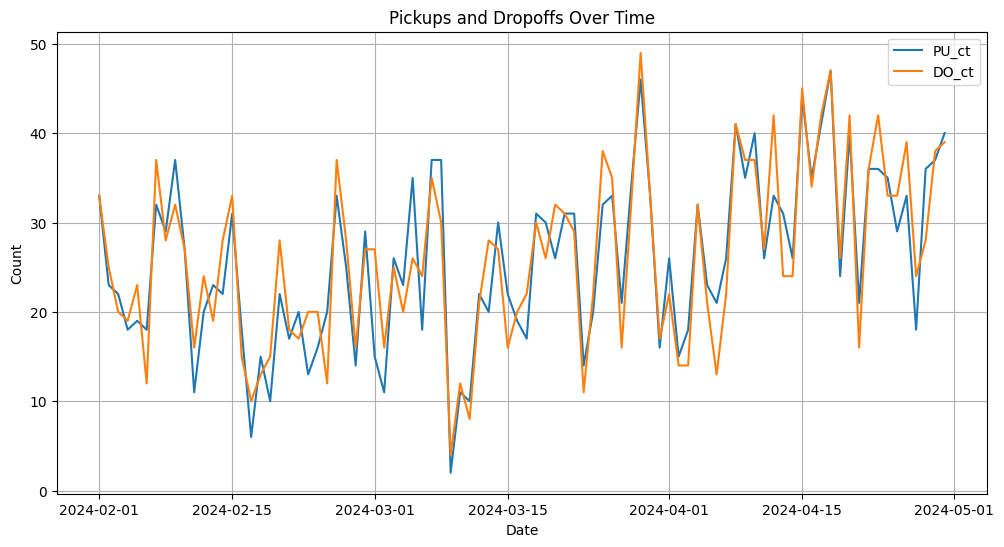

In [ ]:
# plot line chart showing the PU_count and DO_count over time
import matplotlib.pyplot as plt

# Create the line chart
plt.figure(figsize=(12, 6))
plt.plot(PU_DO_counts.index, PU_DO_counts['PU_ct'], label='PU_ct')
plt.plot(PU_DO_counts.index, PU_DO_counts['DO_ct'], label='DO_ct')

# Customize the chart
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Pickups and Dropoffs Over Time')
plt.legend()
plt.grid(True)

plt.show()

# Feature Information: Weather Data
- From https://www.visualcrossing.com/weather-history/

In [ ]:
df_weather = pd.read_csv('/content/drive/My Drive/GW_Class/DNSC6314/Assignments/Data/DC_weather_2024.csv')

df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"washington, dc",2024-01-01,43.0,38.9,40.8,41.8,31.4,36.4,33.3,74.7,...,0.9,1,10,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,Overcast,Cloudy skies throughout the day.,cloudy,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
1,"washington, dc",2024-01-02,45.9,35.7,40.4,40.9,27.2,33.8,26.2,57.3,...,8.3,5,10,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,D6279,72403793728,KADW,KDAA,7..."
2,"washington, dc",2024-01-03,47.8,33.7,39.9,44.6,27.8,36.4,26.6,59.5,...,9.6,5,10,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,D6279,72403793728,KADW,..."
3,"washington, dc",2024-01-04,46.7,33.2,40.4,41.9,24.1,34.6,25.2,55.2,...,4.8,4,10,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,72403793728,KADW,KDAA,7..."
4,"washington, dc",2024-01-05,39.9,27.8,33.6,35.8,19.4,28.0,18.9,55.0,...,11.6,5,10,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C6294,KDCA,72405013743,72403793728,D6279,KADW,..."


In [ ]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              366 non-null    object 
 1   datetime          366 non-null    object 
 2   tempmax           366 non-null    float64
 3   tempmin           366 non-null    float64
 4   temp              366 non-null    float64
 5   feelslikemax      366 non-null    float64
 6   feelslikemin      366 non-null    float64
 7   feelslike         366 non-null    float64
 8   dew               366 non-null    float64
 9   humidity          366 non-null    float64
 10  precip            366 non-null    float64
 11  precipprob        366 non-null    int64  
 12  precipcover       366 non-null    float64
 13  preciptype        134 non-null    object 
 14  snow              366 non-null    float64
 15  snowdepth         366 non-null    float64
 16  windgust          366 non-null    float64
 1

## Drop variables of your choice

In [ ]:
# Drop unnecessary variables
df_weather=df_weather.drop(columns=['name', 'stations','description','sunrise','sunset','conditions','severerisk','preciptype','windgust'])

## Prepare X and y: Merge df_weather with PU_DO_counts

In [ ]:
# Convert the 'datetime' column to datetime objects and extract the date
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather['date'] = df_weather['datetime'].dt.date

# Merge the two dataframes based on the 'date' column
merged_df = pd.merge(PU_DO_counts, df_weather, on='date', how='left')

# Display the merged dataframe
merged_df

,date,PU_ct,DO_ct,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon
0,2024-02-01,33,33,2024-02-01,53.0,31.7,42.4,53.0,26.4,39.3,...,12.0,190.8,1016.3,43.3,8.4,136.8,11.8,5,0.73,partly-cloudy-day
1,2024-02-02,23,25,2024-02-02,51.8,44.0,47.1,51.8,36.6,44.4,...,19.1,354.3,1012.8,97.3,9.8,51.7,4.4,2,0.75,rain
2,2024-02-03,22,20,2024-02-03,51.0,35.8,42.2,51.0,28.0,37.6,...,14.7,354.9,1018.2,11.0,9.9,143.9,12.5,6,0.79,clear-day
3,2024-02-04,18,19,2024-02-04,51.2,32.7,41.7,51.2,27.4,40.7,...,9.2,87.4,1016.0,9.0,9.9,147.4,12.8,6,0.83,clear-day
4,2024-02-05,19,23,2024-02-05,51.8,32.5,41.0,51.8,26.0,37.8,...,12.2,34.9,1013.8,21.4,9.9,145.3,12.7,6,0.86,partly-cloudy-day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2024-04-26,33,39,2024-04-26,64.9,45.5,55.2,64.9,41.5,54.2,...,15.4,116.4,1029.5,69.1,9.9,215.0,18.5,9,0.59,partly-cloudy-day
86,2024-04-27,18,24,2024-04-27,60.1,51.9,55.7,60.1,51.9,55.7,...,10.0,149.9,1030.1,97.3,9.7,44.0,3.9,2,0.63,rain
87,2024-04-28,36,28,2024-04-28,83.1,55.8,67.0,83.3,55.8,67.1,...,10.0,170.0,1021.3,62.1,9.8,213.6,18.5,9,0.67,partly-cloudy-day
88,2024-04-29,37,38,2024-04-29,88.3,62.7,75.2,88.9,62.7,75.3,...,13.0,177.3,1015.6,35.8,9.9,204.5,17.8,9,0.70,partly-cloudy-day


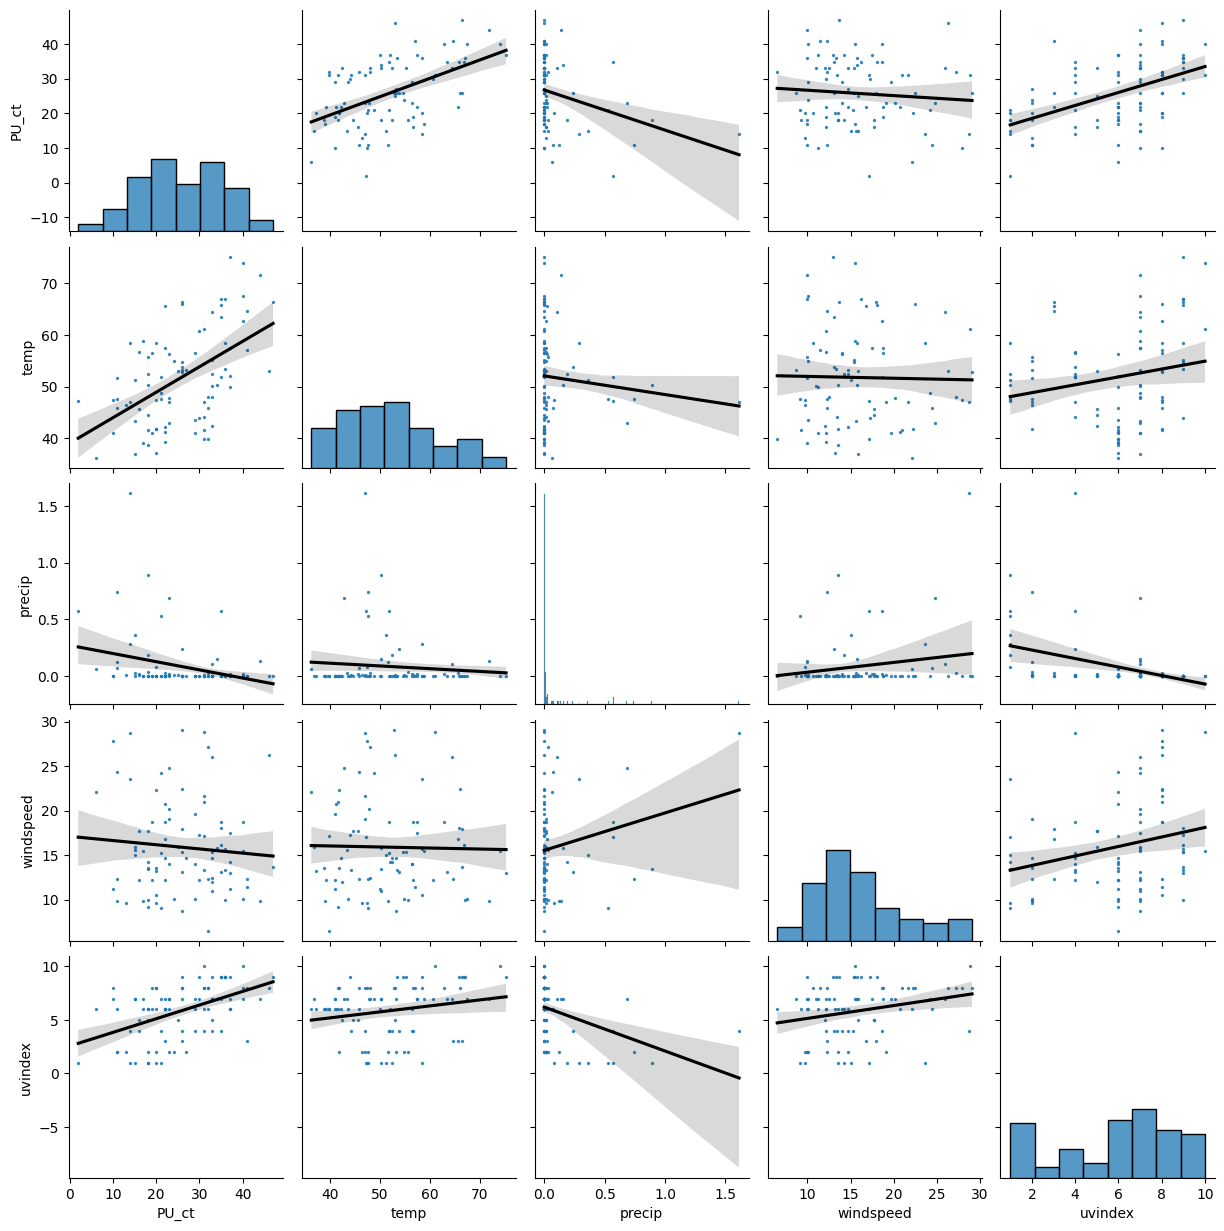

In [ ]:
import seaborn as sns
sns.pairplot(merged_df[['PU_ct',"temp", "precip", "windspeed","uvindex"]], kind="reg",plot_kws=dict(scatter_kws=dict(s=2), line_kws = {'color':'black'})) # pairplot for PU_ct

# Prepare training and test data

In [ ]:
# we have two target variables: PU_ct and DO_ct
y = merged_df[['PU_ct','DO_ct']]
X = merged_df[['temp','precip','windspeed','uvindex','icon']]
X

,temp,precip,windspeed,uvindex,icon
0,42.4,0.000,12.0,5,partly-cloudy-day
1,47.1,0.012,19.1,2,rain
2,42.2,0.000,14.7,6,clear-day
3,41.7,0.000,9.2,6,clear-day
4,41.0,0.000,12.2,6,partly-cloudy-day
...,...,...,...,...,...
85,55.2,0.000,15.4,9,partly-cloudy-day
86,55.7,0.032,10.0,2,rain
87,67.0,0.000,10.0,9,partly-cloudy-day
88,75.2,0.000,13.0,9,partly-cloudy-day


## <font color="red"> Important: train_test_split with y=['PU_ct','DO_ct']. Why? <font>

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.4, random_state = 200) # 40% test data

# **Assignment 1: Regression Models**

## Task 1: Train a linear regression model with a single feature ('temp') for PU_ct, and report the training and test MSE, respectively. [10 pts]

Setting up my environment

In [4]:
# mounting my google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# cloning my github repository to access data files
!git clone https://github.com/chipojaya1/Machine-Learning-I.git


Importing libraries

In [2]:
import pandas as pd

Loading the data

In [6]:
df_Feb = pd.read_csv('202402-capitalbikeshare-tripdata.csv')
df_Mar = pd.read_csv('202403-capitalbikeshare-tripdata.csv')
df_Apr = pd.read_csv('202404-capitalbikeshare-tripdata.csv')

Merging the datasets

In [7]:
df = pd.concat([df_Feb, df_Mar, df_Apr])

Inspecting the dataset

In [8]:
df.shape

(1245899, 13)

In [9]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,24DBACC298E33BF6,electric_bike,2024-02-01 21:18:50,2024-02-01 21:27:36,Eckington Pl & Q St NE,31505.0,5th & K St NW,31600.0,38.910893,-77.005023,38.90304,-77.019027,member
1,FE1067800A18BC56,electric_bike,2024-02-06 17:15:33,2024-02-06 17:30:33,4th & C St SW,31243.0,NaN,NaN,38.886443,-77.017388,38.91000,-76.980000,member
2,AD1962B215B5879D,electric_bike,2024-02-26 13:19:42,2024-02-26 13:30:44,North Capitol St & F St NW,31624.0,NaN,NaN,38.896907,-77.009684,38.90000,-77.010000,member
3,3F8352E6D9EC4F85,electric_bike,2024-02-02 11:01:22,2024-02-02 11:05:14,1st & K St NE,31662.0,NaN,NaN,38.902394,-77.005614,38.90000,-77.010000,member
4,D656DA87FA915F14,electric_bike,2024-02-25 08:28:18,2024-02-25 08:48:44,Virginia Ave & 25th St NW,31297.0,NaN,NaN,38.898456,-77.053075,38.91000,-77.060000,member


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1245899 entries, 0 to 490264
Data columns (total 13 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   ride_id             1245899 non-null  object 
 1   rideable_type       1245899 non-null  object 
 2   started_at          1245899 non-null  object 
 3   ended_at            1245899 non-null  object 
 4   start_station_name  1061748 non-null  object 
 5   start_station_id    1061748 non-null  float64
 6   end_station_name    1052421 non-null  object 
 7   end_station_id      1052253 non-null  float64
 8   start_lat           1245899 non-null  float64
 9   start_lng           1245899 non-null  float64
 10  end_lat             1244884 non-null  float64
 11  end_lng             1244884 non-null  float64
 12  member_casual       1245899 non-null  object 
dtypes: float64(6), object(7)
memory usage: 133.1+ MB


## Task 2: Train a linear regression model with two feature ('temp' and 'precip') for PU_ct, and report the training and test MSE, respectively. [10 pts]

## Task 3: Train a linear regression model with features ('temp','precip','windspeed') for PU_ct, and report the training and test MSE, respectively. [10 pts]

## Task 4: Train a linear regression model with features ('temp','precip','windspeed','uvindex') for PU_ct, and report the training and test MSE, respectively. [10 pts]

## Task 5: Train a linear regression model with features ('temp','precip','windspeed','uvindex','icon') for PU_ct, and report the training and test MSE, respectively. [10 pts]

## Task 6: Based on the previous results, plot the changes in training and test MSEs as more features are added to the linear regression model. [10 pts]

## Task 7: Based on the above plot, identify the best combination of features for PU_ct prediction in linear regression. [10 pts]

## Task 8: Conduct Task 1-7 again for DO_ct prediction. [30 pts]